In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris, load_wine, fetch_openml
from matplotlib.gridspec import GridSpec



# Classification Experiment
This notebook implements a comparative study of different classifiers on UCI datasets, following the approach of Caruana and Niculescu-Mizil.


In [45]:
print("Loading datasets from UCI repository...")
datasets = {
    "Iris": load_iris(as_frame=True),
    "Wine": load_wine(as_frame=True),
    "Heart Disease": fetch_openml(data_id=53, as_frame=True),
    "Diabetes": fetch_openml(data_id=37, as_frame=True)
}

# Convert to binary classification
for name, data in datasets.items():
    if name == "Iris":
        # Setosa vs non-Setosa
        data['target'] = data['target'].apply(lambda x: 1 if x == 0 else 0)
    elif name == "Wine":
        # Class 0 vs others
        data['target'] = data['target'].apply(lambda x: 1 if x == 0 else 0)
    elif name == "Heart Disease":
        # Already binary
        pass
    elif name == "Diabetes":
        # Already binary
        pass

    print(f"Dataset {name} shape: {data['data'].shape}")

Loading datasets from UCI repository...
Dataset Iris shape: (150, 4)
Dataset Wine shape: (178, 13)
Dataset Heart Disease shape: (270, 13)
Dataset Diabetes shape: (768, 8)


In [47]:
# Initialize classifiers with their parameter grids
classifiers = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    "SVM": {
        "model": SVC(random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(random_state=42, max_iter=1000),
        "params": {
            "C": [0.1, 1, 10, 100],
            "penalty": ["l1", "l2"],
            "solver": ["liblinear", "saga"]
        }
    },
    "Neural Network": {
        "model": MLPClassifier(random_state=42, max_iter=1000),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
            "activation": ["relu", "tanh"],
            "alpha": [0.001, 0.01, 0.1],
            "learning_rate": ["constant", "adaptive"]
        }
    }
}


In [48]:
# Setup experiment params
splits = [(0.2, 0.8), (0.5, 0.5), (0.8, 0.2)]
n_trials = 3
results = []



In [49]:
# Run models
for dataset_name, data in datasets.items():
    X, y = data['data'], data['target']
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    for train_size, test_size in splits:
        for trial in range(n_trials):
            # Split data
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=42+trial, stratify=y
            )
            
            for clf_name, clf_info in classifiers.items():
                print(f"Running {clf_name} on {dataset_name} (split {train_size}/{test_size}, trial {trial+1})")
                
                # Grid search
                grid = GridSearchCV(
                    clf_info["model"],
                    clf_info["params"],
                    cv=5,
                    scoring="accuracy",
                    n_jobs=-1
                )
                grid.fit(X_train, y_train)
                
                train_acc = accuracy_score(y_train, grid.predict(X_train))
                test_acc = accuracy_score(y_test, grid.predict(X_test))
                
                # Get validation scores
                val_scores = cross_val_score(
                    grid.best_estimator_,
                    X_train,
                    y_train,
                    cv=5,
                    scoring="accuracy"
                )
                
                results.append({
                    "Dataset": dataset_name,
                    "Classifier": clf_name,
                    "Train Size": train_size,
                    "Test Size": test_size,
                    "Trial": trial + 1,
                    "Train Accuracy": train_acc,
                    "Validation Accuracy": val_scores.mean(),
                    "Test Accuracy": test_acc,
                    "Best Parameters": grid.best_params_,
                    "CV Score": grid.best_score_
                })

Running Random Forest on Iris (split 0.2/0.8, trial 1)
Running SVM on Iris (split 0.2/0.8, trial 1)
Running KNN on Iris (split 0.2/0.8, trial 1)
Running Logistic Regression on Iris (split 0.2/0.8, trial 1)
Running Neural Network on Iris (split 0.2/0.8, trial 1)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Iris (split 0.2/0.8, trial 2)
Running SVM on Iris (split 0.2/0.8, trial 2)
Running KNN on Iris (split 0.2/0.8, trial 2)
Running Logistic Regression on Iris (split 0.2/0.8, trial 2)
Running Neural Network on Iris (split 0.2/0.8, trial 2)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Iris (split 0.2/0.8, trial 3)
Running SVM on Iris (split 0.2/0.8, trial 3)
Running KNN on Iris (split 0.2/0.8, trial 3)
Running Logistic Regression on Iris (split 0.2/0.8, trial 3)
Running Neural Network on Iris (split 0.2/0.8, trial 3)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Iris (split 0.5/0.5, trial 1)
Running SVM on Iris (split 0.5/0.5, trial 1)
Running KNN on Iris (split 0.5/0.5, trial 1)
Running Logistic Regression on Iris (split 0.5/0.5, trial 1)
Running Neural Network on Iris (split 0.5/0.5, trial 1)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Iris (split 0.5/0.5, trial 2)
Running SVM on Iris (split 0.5/0.5, trial 2)
Running KNN on Iris (split 0.5/0.5, trial 2)
Running Logistic Regression on Iris (split 0.5/0.5, trial 2)
Running Neural Network on Iris (split 0.5/0.5, trial 2)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Iris (split 0.5/0.5, trial 3)
Running SVM on Iris (split 0.5/0.5, trial 3)
Running KNN on Iris (split 0.5/0.5, trial 3)
Running Logistic Regression on Iris (split 0.5/0.5, trial 3)
Running Neural Network on Iris (split 0.5/0.5, trial 3)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Iris (split 0.8/0.2, trial 1)
Running SVM on Iris (split 0.8/0.2, trial 1)
Running KNN on Iris (split 0.8/0.2, trial 1)
Running Logistic Regression on Iris (split 0.8/0.2, trial 1)
Running Neural Network on Iris (split 0.8/0.2, trial 1)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Iris (split 0.8/0.2, trial 2)
Running SVM on Iris (split 0.8/0.2, trial 2)
Running KNN on Iris (split 0.8/0.2, trial 2)
Running Logistic Regression on Iris (split 0.8/0.2, trial 2)
Running Neural Network on Iris (split 0.8/0.2, trial 2)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Iris (split 0.8/0.2, trial 3)
Running SVM on Iris (split 0.8/0.2, trial 3)
Running KNN on Iris (split 0.8/0.2, trial 3)
Running Logistic Regression on Iris (split 0.8/0.2, trial 3)
Running Neural Network on Iris (split 0.8/0.2, trial 3)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Wine (split 0.2/0.8, trial 1)
Running SVM on Wine (split 0.2/0.8, trial 1)
Running KNN on Wine (split 0.2/0.8, trial 1)
Running Logistic Regression on Wine (split 0.2/0.8, trial 1)
Running Neural Network on Wine (split 0.2/0.8, trial 1)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Wine (split 0.2/0.8, trial 2)
Running SVM on Wine (split 0.2/0.8, trial 2)
Running KNN on Wine (split 0.2/0.8, trial 2)
Running Logistic Regression on Wine (split 0.2/0.8, trial 2)
Running Neural Network on Wine (split 0.2/0.8, trial 2)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Wine (split 0.2/0.8, trial 3)
Running SVM on Wine (split 0.2/0.8, trial 3)
Running KNN on Wine (split 0.2/0.8, trial 3)
Running Logistic Regression on Wine (split 0.2/0.8, trial 3)
Running Neural Network on Wine (split 0.2/0.8, trial 3)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Wine (split 0.5/0.5, trial 1)
Running SVM on Wine (split 0.5/0.5, trial 1)
Running KNN on Wine (split 0.5/0.5, trial 1)
Running Logistic Regression on Wine (split 0.5/0.5, trial 1)
Running Neural Network on Wine (split 0.5/0.5, trial 1)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Wine (split 0.5/0.5, trial 2)
Running SVM on Wine (split 0.5/0.5, trial 2)
Running KNN on Wine (split 0.5/0.5, trial 2)
Running Logistic Regression on Wine (split 0.5/0.5, trial 2)
Running Neural Network on Wine (split 0.5/0.5, trial 2)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Wine (split 0.5/0.5, trial 3)
Running SVM on Wine (split 0.5/0.5, trial 3)
Running KNN on Wine (split 0.5/0.5, trial 3)
Running Logistic Regression on Wine (split 0.5/0.5, trial 3)
Running Neural Network on Wine (split 0.5/0.5, trial 3)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Wine (split 0.8/0.2, trial 1)
Running SVM on Wine (split 0.8/0.2, trial 1)
Running KNN on Wine (split 0.8/0.2, trial 1)
Running Logistic Regression on Wine (split 0.8/0.2, trial 1)
Running Neural Network on Wine (split 0.8/0.2, trial 1)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Wine (split 0.8/0.2, trial 2)
Running SVM on Wine (split 0.8/0.2, trial 2)
Running KNN on Wine (split 0.8/0.2, trial 2)
Running Logistic Regression on Wine (split 0.8/0.2, trial 2)
Running Neural Network on Wine (split 0.8/0.2, trial 2)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Wine (split 0.8/0.2, trial 3)
Running SVM on Wine (split 0.8/0.2, trial 3)
Running KNN on Wine (split 0.8/0.2, trial 3)
Running Logistic Regression on Wine (split 0.8/0.2, trial 3)
Running Neural Network on Wine (split 0.8/0.2, trial 3)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Heart Disease (split 0.2/0.8, trial 1)
Running SVM on Heart Disease (split 0.2/0.8, trial 1)
Running KNN on Heart Disease (split 0.2/0.8, trial 1)
Running Logistic Regression on Heart Disease (split 0.2/0.8, trial 1)
Running Neural Network on Heart Disease (split 0.2/0.8, trial 1)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Heart Disease (split 0.2/0.8, trial 2)
Running SVM on Heart Disease (split 0.2/0.8, trial 2)
Running KNN on Heart Disease (split 0.2/0.8, trial 2)
Running Logistic Regression on Heart Disease (split 0.2/0.8, trial 2)
Running Neural Network on Heart Disease (split 0.2/0.8, trial 2)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Heart Disease (split 0.2/0.8, trial 3)
Running SVM on Heart Disease (split 0.2/0.8, trial 3)
Running KNN on Heart Disease (split 0.2/0.8, trial 3)
Running Logistic Regression on Heart Disease (split 0.2/0.8, trial 3)
Running Neural Network on Heart Disease (split 0.2/0.8, trial 3)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Running Random Forest on Heart Disease (split 0.5/0.5, trial 1)
Running SVM on Heart Disease (split 0.5/0.5, trial 1)
Running KNN on Heart Disease (split 0.5/0.5, trial 1)
Running Logistic Regression on Heart Disease (split 0.5/0.5, trial 1)
Running Neural Network on Heart Disease (split 0.5/0.5, trial 1)
Running Random Forest on Heart Disease (split 0.5/0.5, trial 2)
Running SVM on Heart Disease (split 0.5/0.5, trial 2)
Running KNN on Heart Disease (split 0.5/0.5, trial 2)
Running Logistic Regression on Heart Disease (split 0.5/0.5, trial 2)
Running Neural Network on Heart Disease (split 0.5/0.5, trial 2)
Running Random Forest on Heart Disease (split 0.5/0.5, trial 3)
Running SVM on Heart Disease (split 0.5/0.5, trial 3)
Running KNN on Heart Disease (split 0.5/0.5, trial 3)
Running Logistic Regression on Heart Disease (split 0.5/0.5, trial 3)
Running Neural Network on Heart Disease (split 0.5/0.5, trial 3)
Running Random Forest on Heart Disease (split 0.8/0.2, trial 1)
Running SVM on 

/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

Running Random Forest on Heart Disease (split 0.8/0.2, trial 2)
Running SVM on Heart Disease (split 0.8/0.2, trial 2)
Running KNN on Heart Disease (split 0.8/0.2, trial 2)
Running Logistic Regression on Heart Disease (split 0.8/0.2, trial 2)
Running Neural Network on Heart Disease (split 0.8/0.2, trial 2)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

Running Random Forest on Heart Disease (split 0.8/0.2, trial 3)
Running SVM on Heart Disease (split 0.8/0.2, trial 3)
Running KNN on Heart Disease (split 0.8/0.2, trial 3)
Running Logistic Regression on Heart Disease (split 0.8/0.2, trial 3)
Running Neural Network on Heart Disease (split 0.8/0.2, trial 3)
Running Random Forest on Diabetes (split 0.2/0.8, trial 1)
Running SVM on Diabetes (split 0.2/0.8, trial 1)
Running KNN on Diabetes (split 0.2/0.8, trial 1)
Running Logistic Regression on Diabetes (split 0.2/0.8, trial 1)
Running Neural Network on Diabetes (split 0.2/0.8, trial 1)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

Running Random Forest on Diabetes (split 0.2/0.8, trial 2)
Running SVM on Diabetes (split 0.2/0.8, trial 2)
Running KNN on Diabetes (split 0.2/0.8, trial 2)
Running Logistic Regression on Diabetes (split 0.2/0.8, trial 2)
Running Neural Network on Diabetes (split 0.2/0.8, trial 2)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

Running Random Forest on Diabetes (split 0.2/0.8, trial 3)
Running SVM on Diabetes (split 0.2/0.8, trial 3)
Running KNN on Diabetes (split 0.2/0.8, trial 3)
Running Logistic Regression on Diabetes (split 0.2/0.8, trial 3)
Running Neural Network on Diabetes (split 0.2/0.8, trial 3)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

Running Random Forest on Diabetes (split 0.5/0.5, trial 1)
Running SVM on Diabetes (split 0.5/0.5, trial 1)
Running KNN on Diabetes (split 0.5/0.5, trial 1)
Running Logistic Regression on Diabetes (split 0.5/0.5, trial 1)
Running Neural Network on Diabetes (split 0.5/0.5, trial 1)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

Running Random Forest on Diabetes (split 0.5/0.5, trial 2)
Running SVM on Diabetes (split 0.5/0.5, trial 2)
Running KNN on Diabetes (split 0.5/0.5, trial 2)
Running Logistic Regression on Diabetes (split 0.5/0.5, trial 2)
Running Neural Network on Diabetes (split 0.5/0.5, trial 2)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

Running Random Forest on Diabetes (split 0.5/0.5, trial 3)
Running SVM on Diabetes (split 0.5/0.5, trial 3)
Running KNN on Diabetes (split 0.5/0.5, trial 3)
Running Logistic Regression on Diabetes (split 0.5/0.5, trial 3)
Running Neural Network on Diabetes (split 0.5/0.5, trial 3)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

Running Random Forest on Diabetes (split 0.8/0.2, trial 1)
Running SVM on Diabetes (split 0.8/0.2, trial 1)
Running KNN on Diabetes (split 0.8/0.2, trial 1)
Running Logistic Regression on Diabetes (split 0.8/0.2, trial 1)
Running Neural Network on Diabetes (split 0.8/0.2, trial 1)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

Running Random Forest on Diabetes (split 0.8/0.2, trial 2)
Running SVM on Diabetes (split 0.8/0.2, trial 2)
Running KNN on Diabetes (split 0.8/0.2, trial 2)
Running Logistic Regression on Diabetes (split 0.8/0.2, trial 2)
Running Neural Network on Diabetes (split 0.8/0.2, trial 2)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

Running Random Forest on Diabetes (split 0.8/0.2, trial 3)
Running SVM on Diabetes (split 0.8/0.2, trial 3)
Running KNN on Diabetes (split 0.8/0.2, trial 3)
Running Logistic Regression on Diabetes (split 0.8/0.2, trial 3)
Running Neural Network on Diabetes (split 0.8/0.2, trial 3)


/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cogs_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

In [50]:
results_df = pd.DataFrame(results)
print("\nSaving results to CSV...")
results_df.to_csv("classification_results_1.csv", index=False)



Saving results to CSV...



## Summary Statistics
Display average performance across all trials for each classifier and dataset combination


In [68]:
summary = results_df.pivot_table(
    index=["Dataset", "Train Size"],
    columns="Classifier",
    values=["Train Accuracy", "Validation Accuracy", "Test Accuracy"],
    aggfunc="mean"
)
print("\nDetailed Performance Summary:")
print(summary)


Detailed Performance Summary:
                         Test Accuracy                                     \
Classifier                         KNN Logistic Regression Neural Network   
Dataset       Train Size                                                    
Diabetes      0.2             0.729539            0.746341       0.716531   
              0.5             0.729167            0.760417       0.728299   
              0.8             0.746753            0.757576       0.753247   
Heart Disease 0.2             0.817901            0.804012       0.790123   
              0.5             0.832099            0.834568       0.804938   
              0.8             0.771605            0.808642       0.820988   
Iris          0.2             1.000000            0.994444       1.000000   
              0.5             1.000000            1.000000       1.000000   
              0.8             0.988889            1.000000       1.000000   
Wine          0.2             0.969697       

# Figures

In [85]:

# Load results
results_df = pd.read_csv("classification_results_1.csv")
avg_results = results_df.groupby(
    ["Dataset", "Classifier", "Train Size"]
)[["Train Accuracy", "Validation Accuracy", "Test Accuracy"]].mean().reset_index()

COLOR_PALETTE = {
    'primary': [
        '#4e79a7',  
        '#f28e2c',  
        '#e15759',  
        '#76b7b2',  
        '#59a14f'
    ],
    'comparison': [
        '#67a9cf',
        '#ef8a62',
        '#998ec3'
    ],
    'reference': '#636363'
}

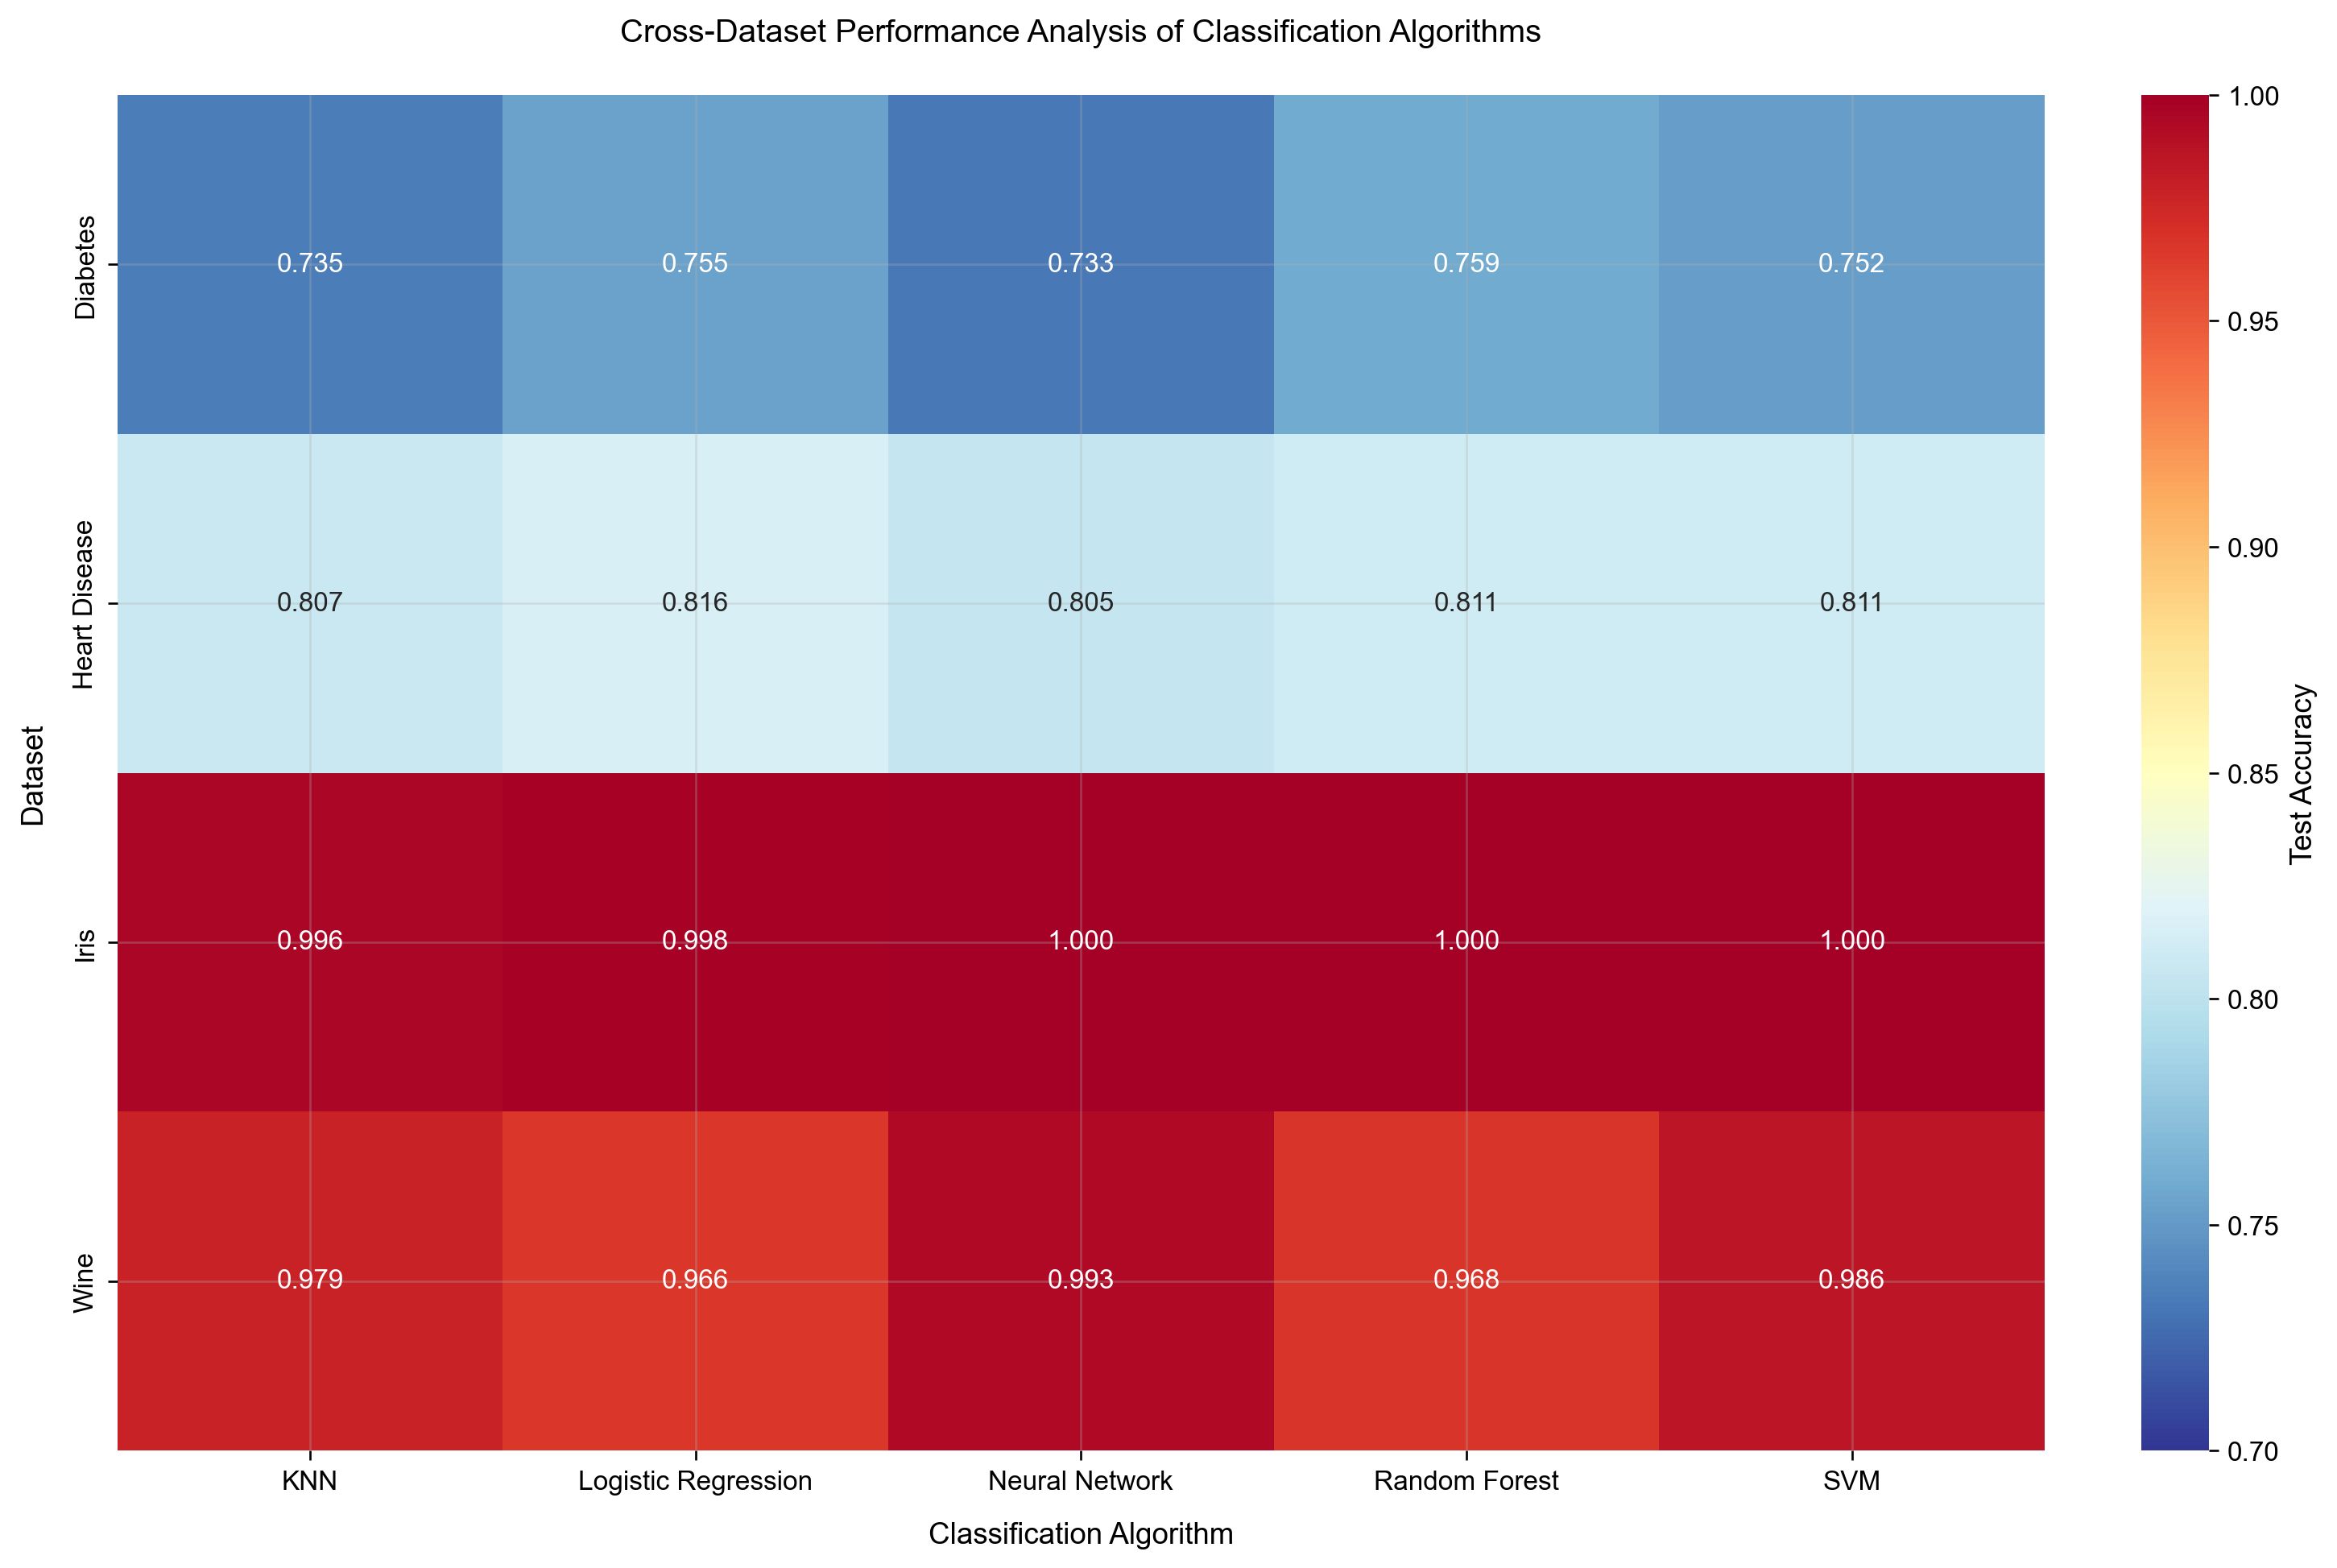

In [94]:
# Figure 1: Performance Heatmap
def heatmap(results_df):
    plt.figure(figsize=(12, 8))
    heatmap_data = results_df.groupby(['Dataset', 'Classifier'])['Test Accuracy'].mean().unstack()
    
    sns.heatmap(heatmap_data, 
                annot=True, 
                cmap='RdYlBu_r',
                fmt='.3f',
                vmin=0.7, 
                vmax=1.0,
                cbar_kws={'label': 'Test Accuracy'})
    
    plt.title('Cross-Dataset Performance Analysis of Classification Algorithms',
              pad=20)
    plt.xlabel('Classification Algorithm', labelpad=10)
    plt.ylabel('Dataset', labelpad=10)
    
    plt.show()

heatmap(results_df)


/var/folders/tx/vgccmrkj1fz1zv99j496_3k80000gn/T/ipykernel_46375/2704461797.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


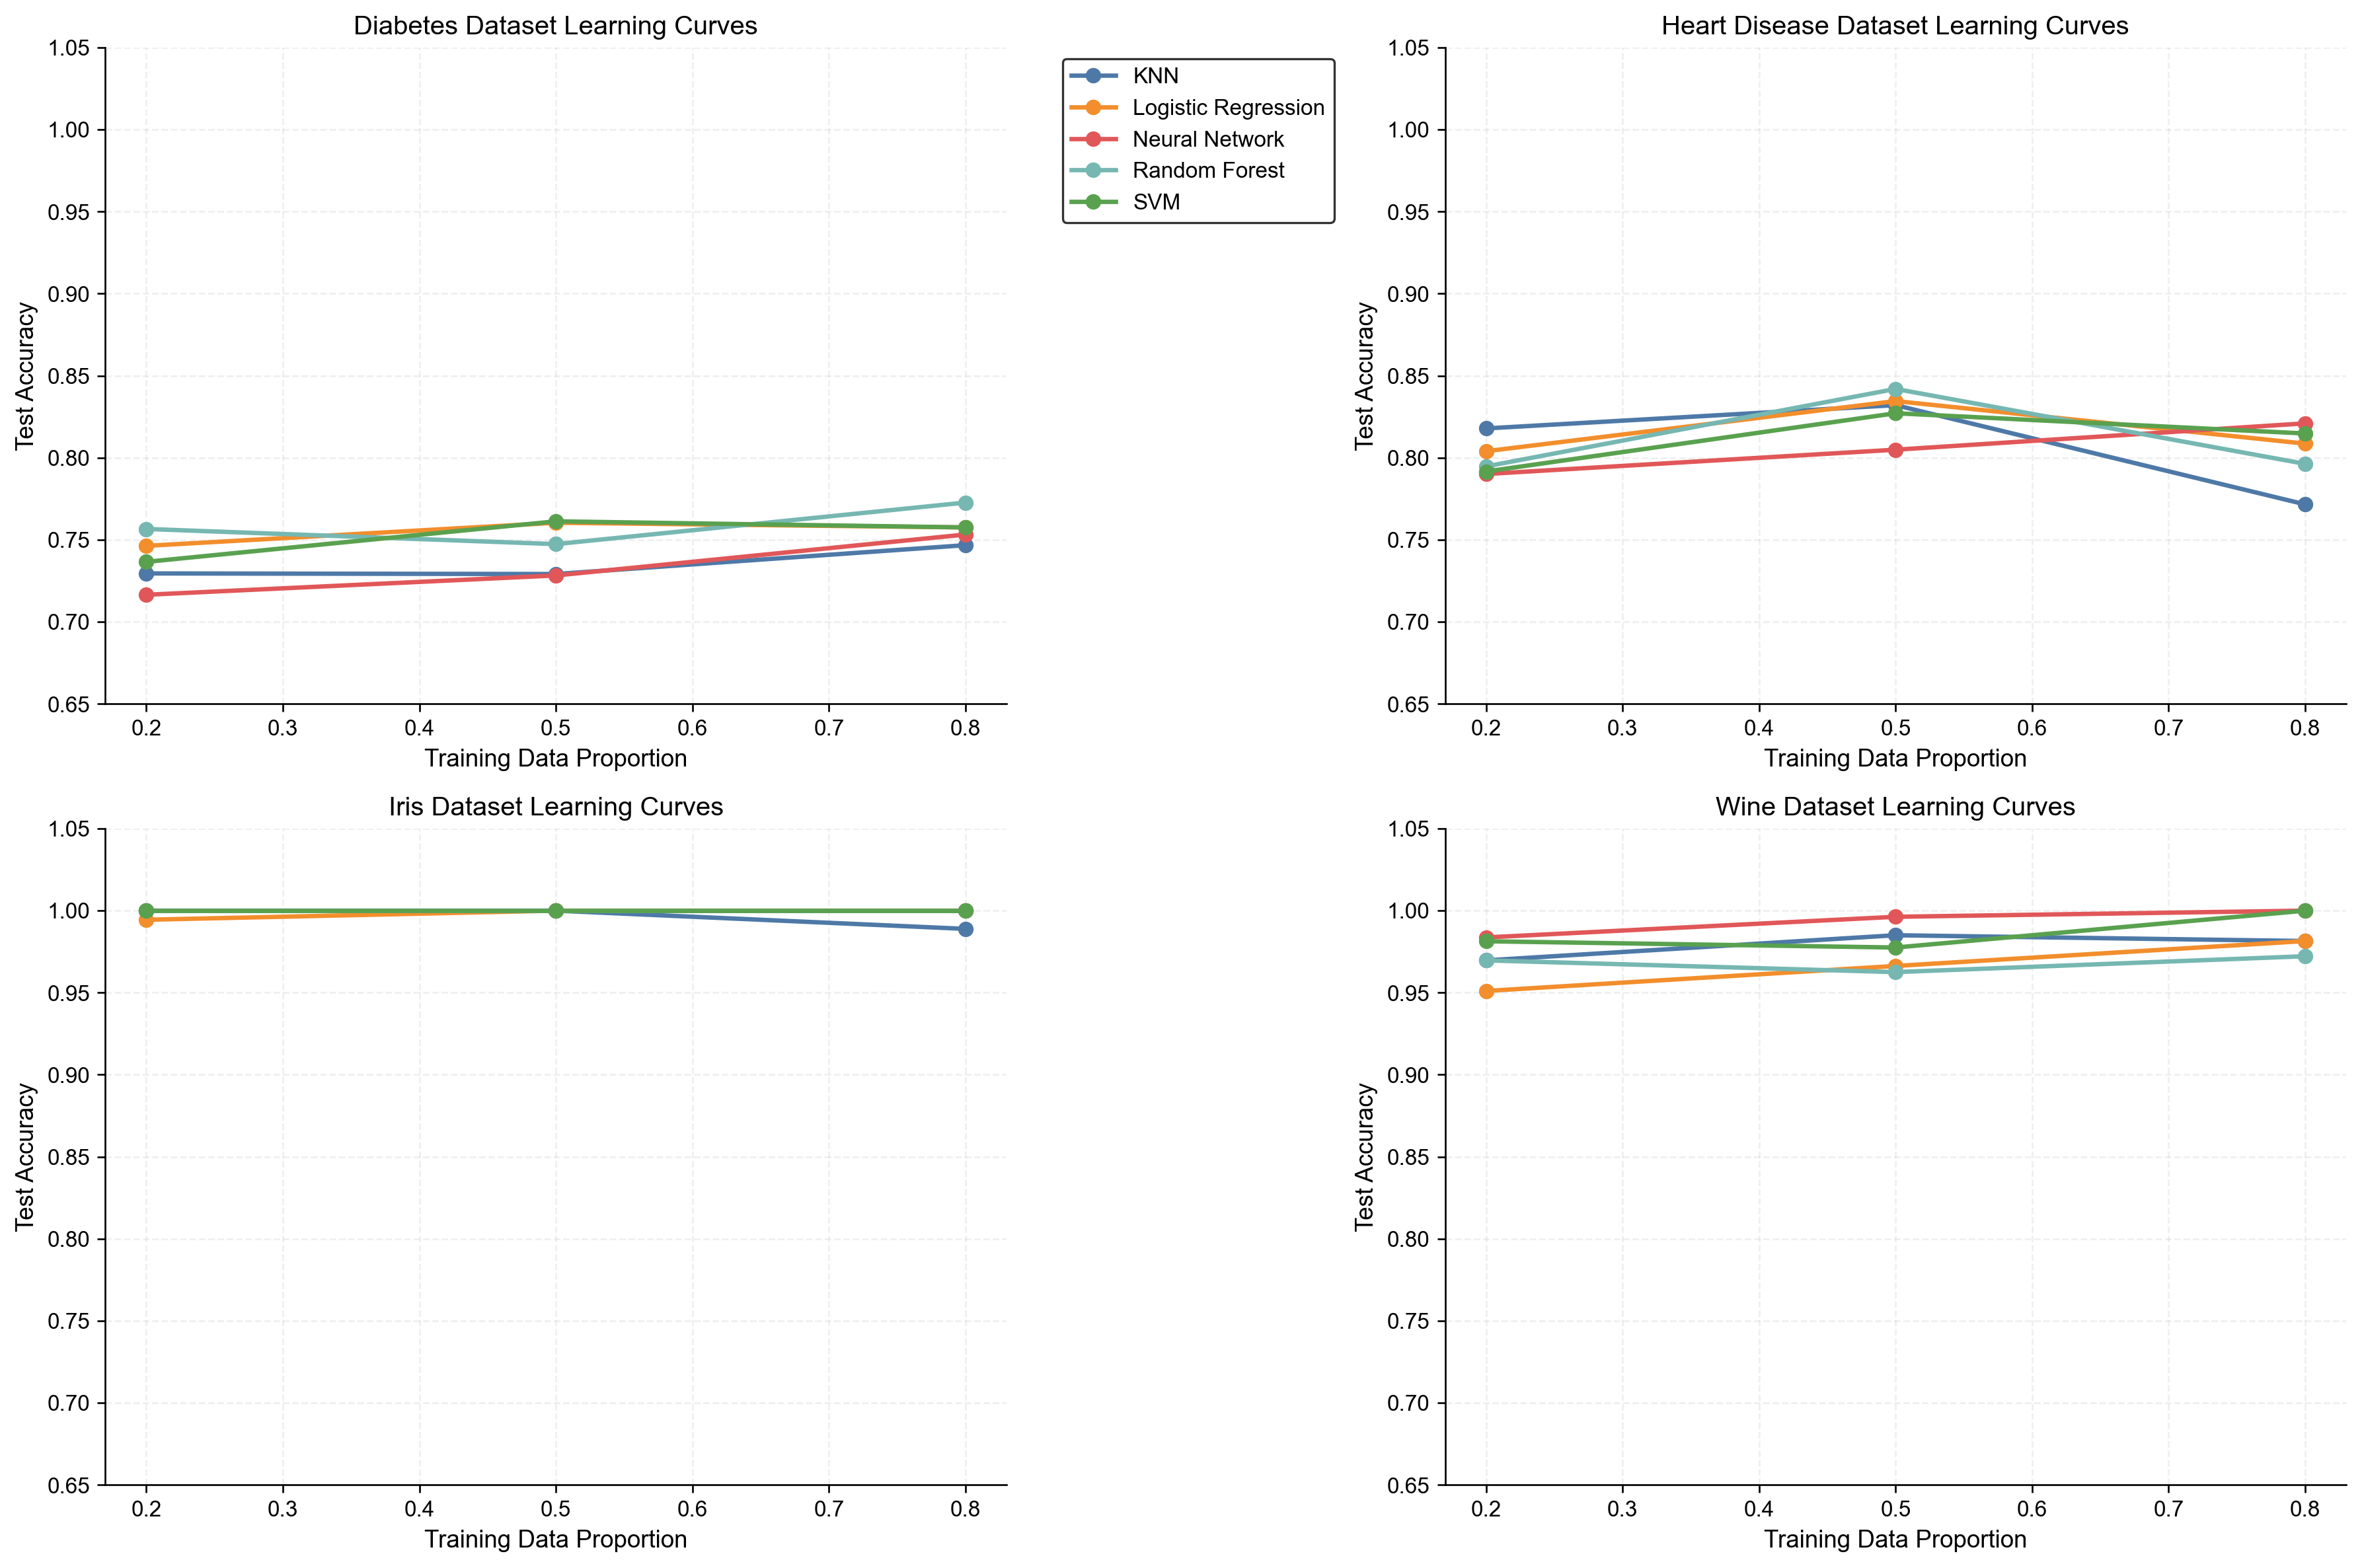

In [95]:
# Figure 2: Learning Curves

def learning_curve(heatmap_data, avg_results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, dataset_name in enumerate(heatmap_data.index):
        ax = axes[idx]
        dataset_results = avg_results[avg_results["Dataset"] == dataset_name]
        
        for color_idx, clf_name in enumerate(heatmap_data.columns):
            clf_results = dataset_results[dataset_results["Classifier"] == clf_name]
            ax.plot(clf_results["Train Size"], 
                   clf_results["Test Accuracy"],
                   color=COLOR_PALETTE['primary'][color_idx],
                   marker='o', 
                   label=clf_name, 
                   linewidth=2,
                   markersize=6)
        
        ax.set_title(f"{dataset_name} Dataset Learning Curves")
        ax.set_xlabel("Training Data Proportion")
        ax.set_ylabel("Test Accuracy")
        ax.grid(True, alpha=0.2, linestyle='--')
        ax.set_ylim(0.65, 1.05)
        
        if idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), 
                     loc='upper left',
                     frameon=True,
                     edgecolor='black')
    
    plt.tight_layout()
    plt.show()

heatmap_data = results_df.groupby(['Dataset', 'Classifier'])['Test Accuracy'].mean().unstack()

learning_curve(heatmap_data, avg_results)


/var/folders/tx/vgccmrkj1fz1zv99j496_3k80000gn/T/ipykernel_46375/1781691798.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


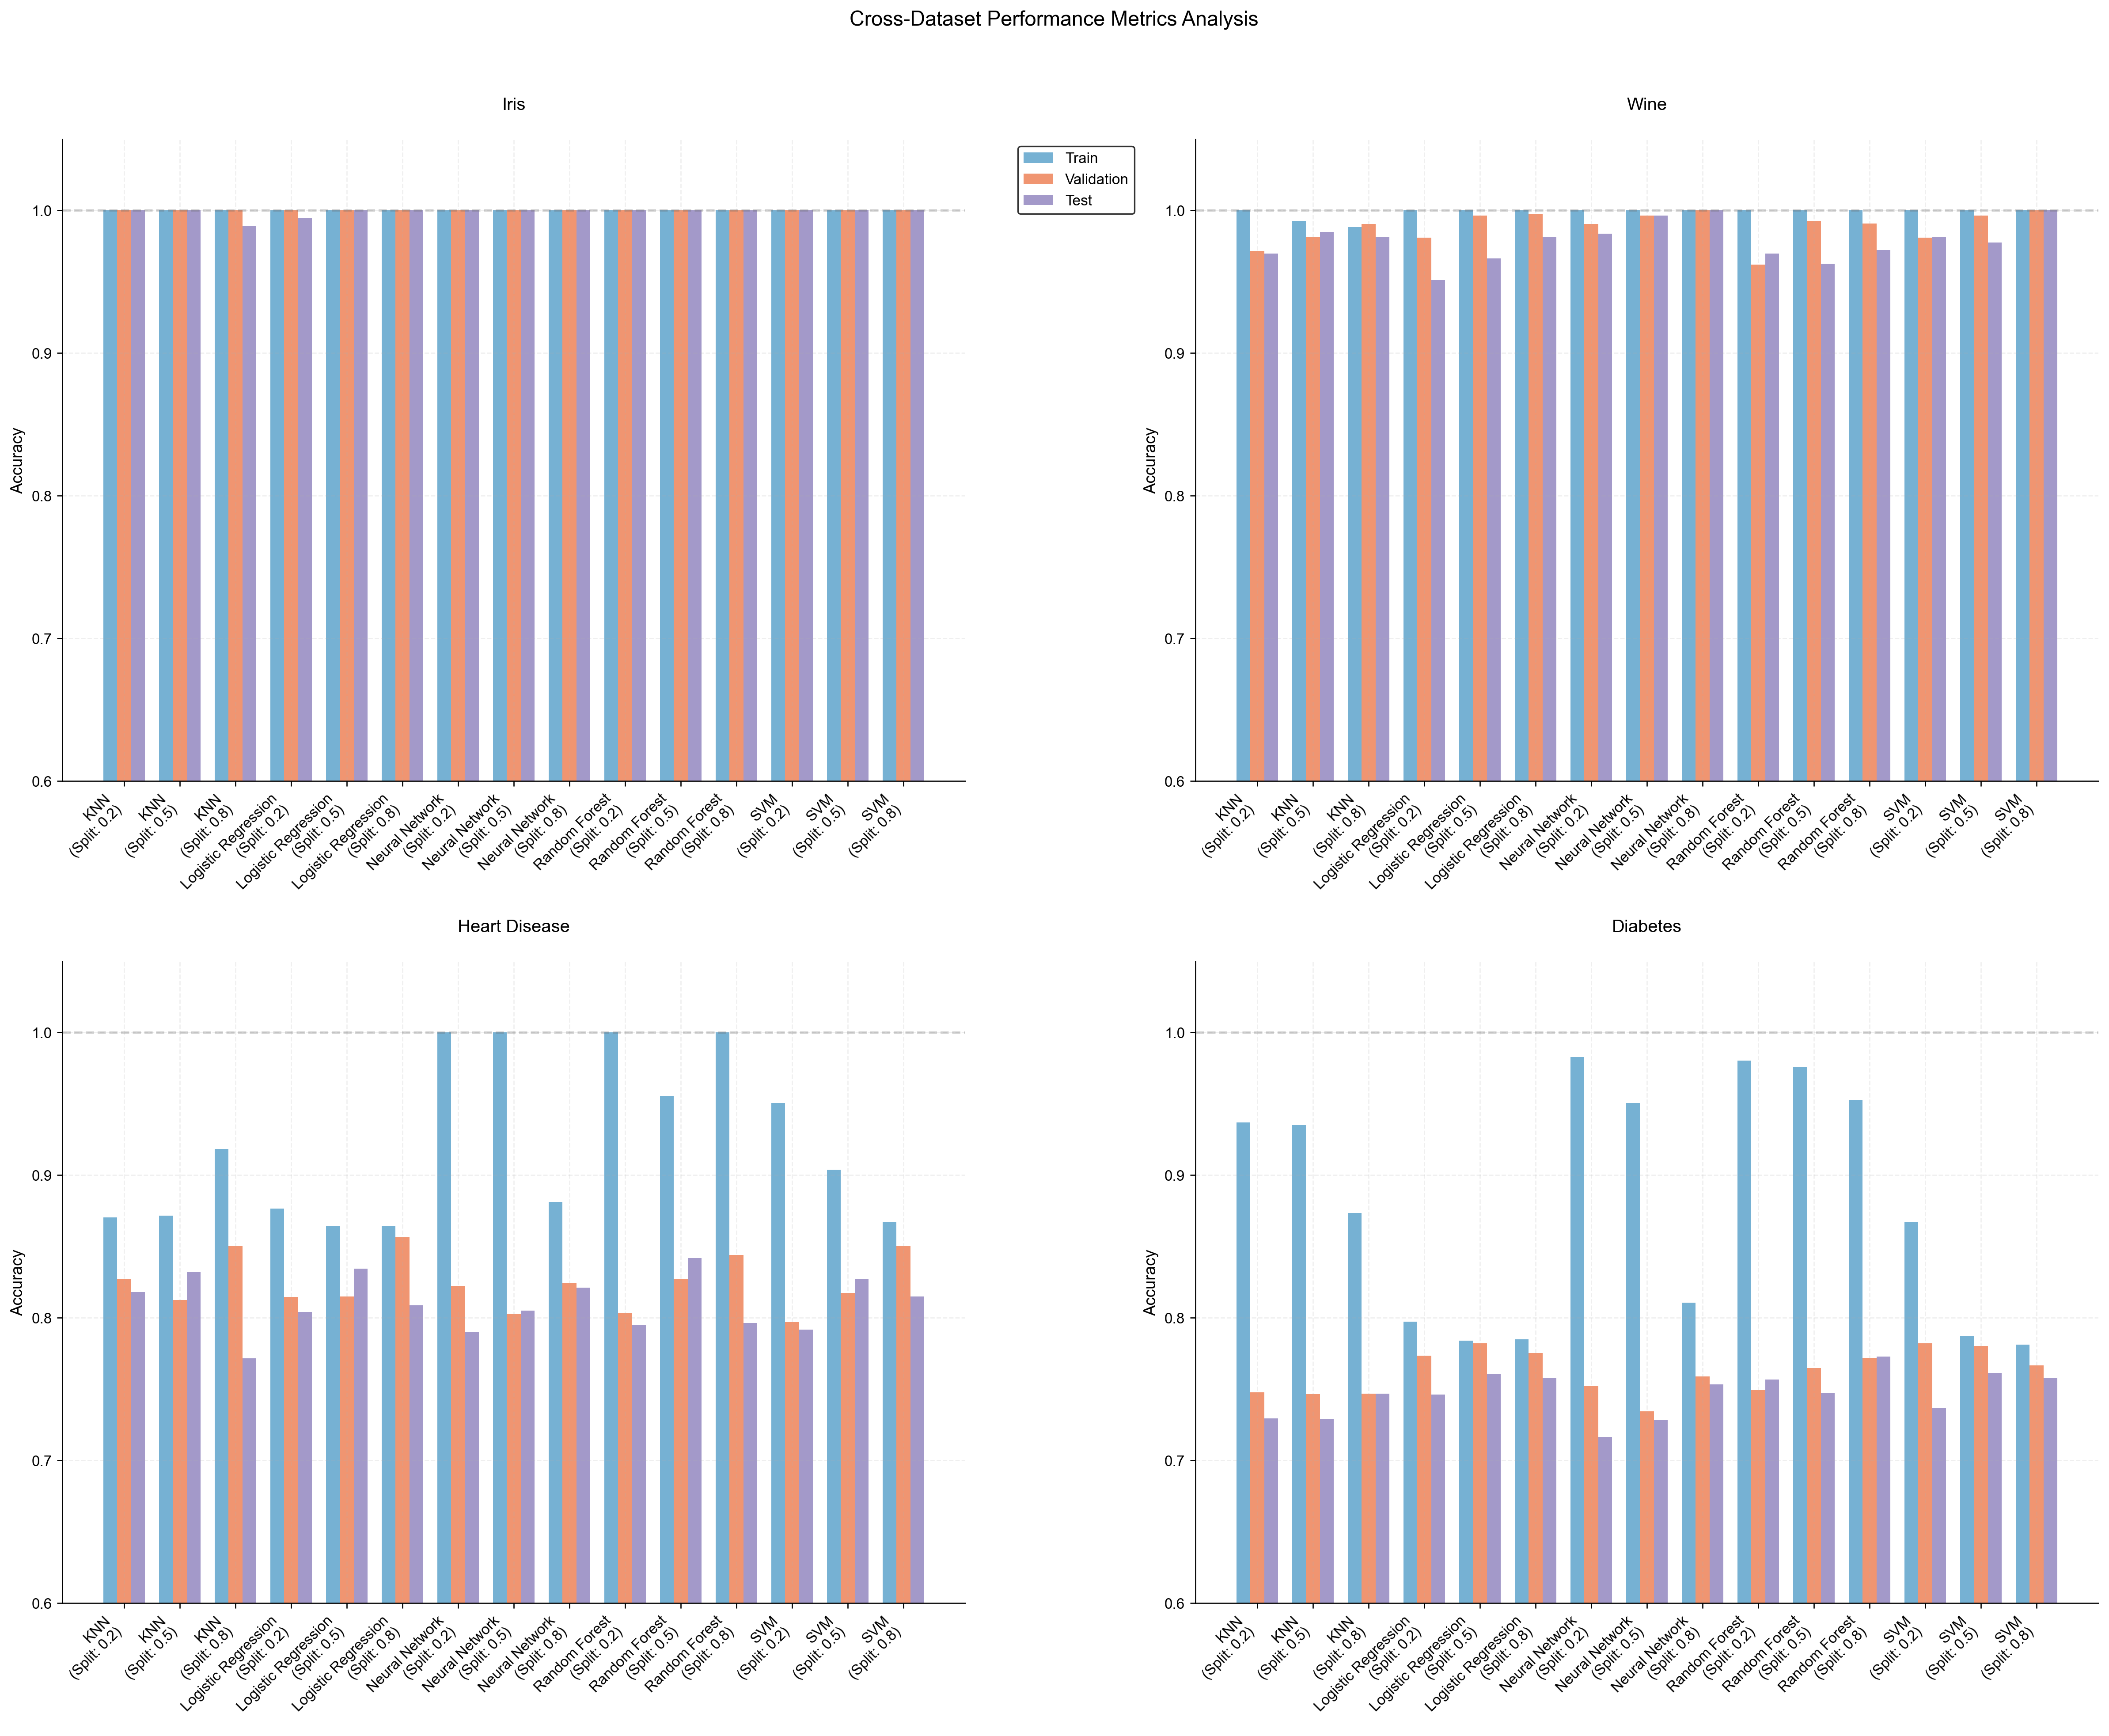

In [96]:

def gap_analysis_grid():
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.ravel()
    
    width = 0.25
    alpha = 0.9
    
    for idx, dataset_name in enumerate(results_df['Dataset'].unique()):
        dataset_results = avg_results[avg_results["Dataset"] == dataset_name]
        x = np.arange(len(dataset_results))
        
        axes[idx].bar(x - width, dataset_results['Train Accuracy'],
                     width, label='Train', 
                     color=COLOR_PALETTE['comparison'][0], 
                     alpha=alpha)
        axes[idx].bar(x, dataset_results['Validation Accuracy'],
                     width, label='Validation', 
                     color=COLOR_PALETTE['comparison'][1], 
                     alpha=alpha)
        axes[idx].bar(x + width, dataset_results['Test Accuracy'],
                     width, label='Test', 
                     color=COLOR_PALETTE['comparison'][2], 
                     alpha=alpha)
        
        axes[idx].set_ylabel('Accuracy')
        axes[idx].set_title(f'{dataset_name}', fontsize=12, pad=20)
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels([f"{row['Classifier']}\n(Split: {row['Train Size']})"
                                  for _, row in dataset_results.iterrows()],
                                  rotation=45, ha='right')
        
        axes[idx].set_ylim(0.6, 1.05)
        axes[idx].grid(True, alpha=0.2, linestyle='--')
        
        if idx == 0:
            axes[idx].legend(bbox_to_anchor=(1.05, 1), 
                           loc='upper left',
                           frameon=True,
                           edgecolor='black')
        
        axes[idx].axhline(y=1.0, 
                         color=COLOR_PALETTE['reference'], 
                         linestyle='--', 
                         alpha=0.3)
    
    plt.suptitle('Cross-Dataset Performance Metrics Analysis', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

gap_analysis_grid()


/var/folders/tx/vgccmrkj1fz1zv99j496_3k80000gn/T/ipykernel_46375/2120977634.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


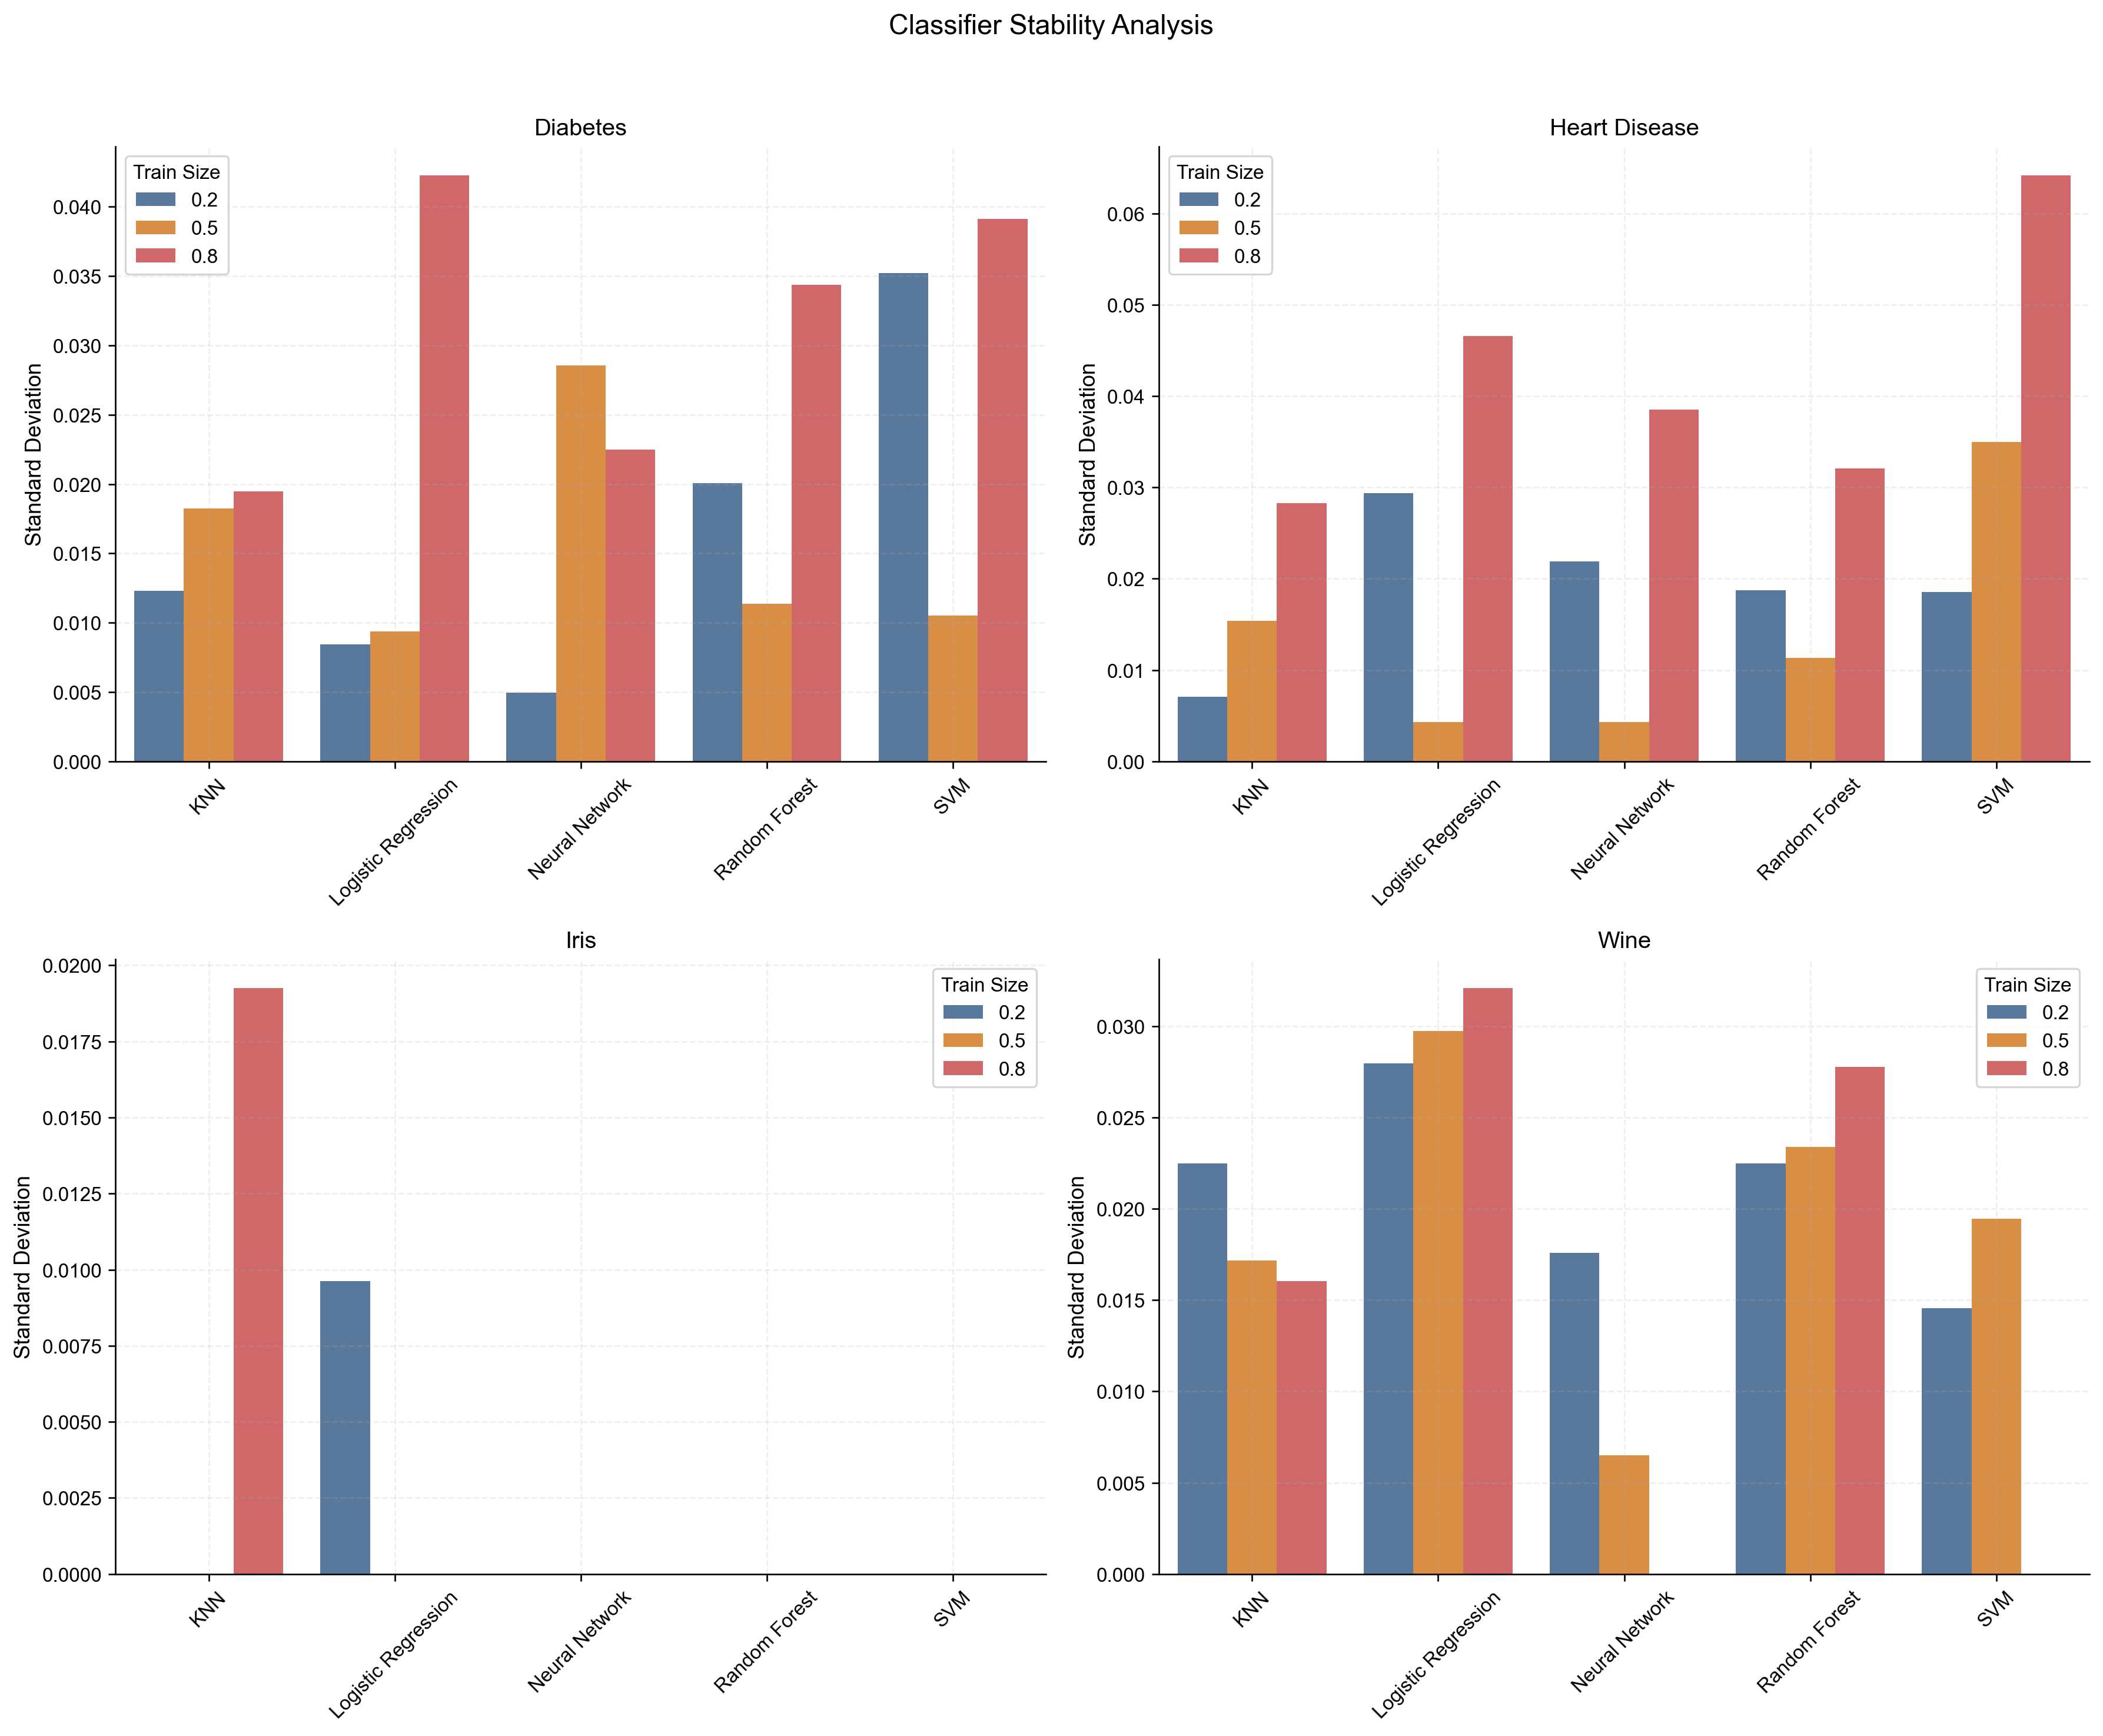

In [97]:
# Figure 4: Stability Analysis
def stability_analysis(results_df):

    stability_data = results_df.groupby(['Dataset', 'Classifier', 'Train Size'])['Test Accuracy'].agg(['mean', 'std']).reset_index()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, dataset in enumerate(stability_data['Dataset'].unique()):
        dataset_stability = stability_data[stability_data['Dataset'] == dataset]
        
        sns.barplot(data=dataset_stability,
                   x='Classifier',
                   y='std',
                   hue='Train Size',
                   palette=COLOR_PALETTE['primary'][:len(dataset_stability['Train Size'].unique())],
                   ax=axes[idx])
        
        axes[idx].set_title(f"{dataset}")
        axes[idx].set_xlabel("")
        axes[idx].set_ylabel("Standard Deviation")
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.2, linestyle='--')
    
    plt.suptitle("Classifier Stability Analysis", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

stability_analysis(results_df)